In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
import tkinter as tk
from surprise.model_selection import cross_validate, train_test_split
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
from tkinter import Tk, Label, Entry, Button, Text, END, StringVar, OptionMenu


In [2]:
# Load the dataset
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [7]:
movies.shape

(9742, 3)

In [8]:
ratings.shape

(100836, 4)

In [9]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [10]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Data Visualization

In [13]:
genres=[]
for genre in movies.genres:
    x=genre.split('|')
    for i in x:
         if i not in genres:
            genres.append(str(i))
genres=str(genres)    
movie_title=[]
for title in movies.title:
    movie_title.append(title[0:-7])
movie_title=str(movie_title)    

In [14]:
wordcloud_genre=WordCloud(width=1500,height=800,background_color='black',min_font_size=2,min_word_length=3).generate(genres)
wordcloud_title=WordCloud(width=1500,height=800,background_color='cyan',min_font_size=2,min_word_length=3).generate(movie_title)

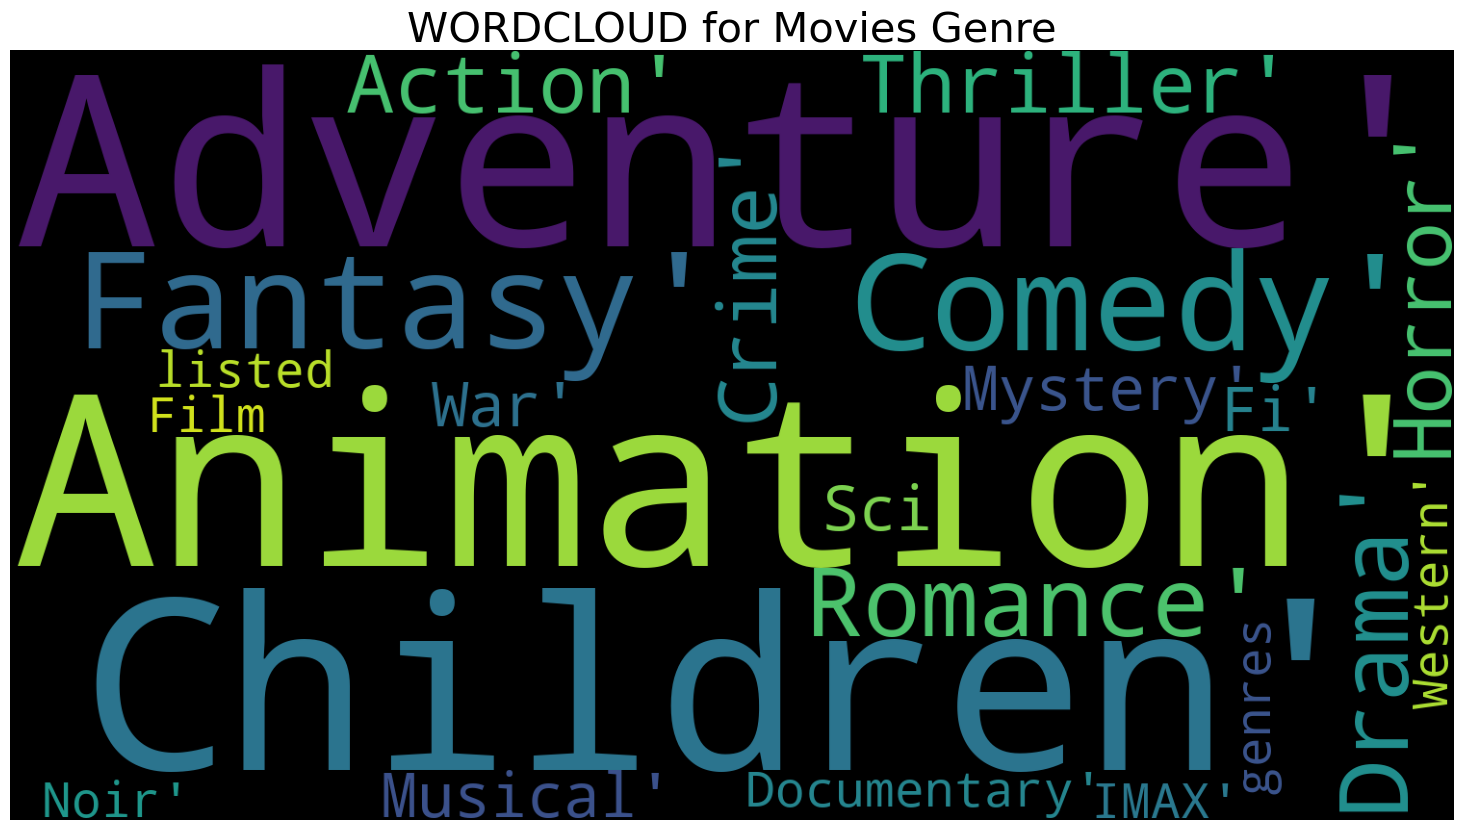

In [15]:
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('WORDCLOUD for Movies Genre',fontsize=30)
plt.imshow(wordcloud_genre)

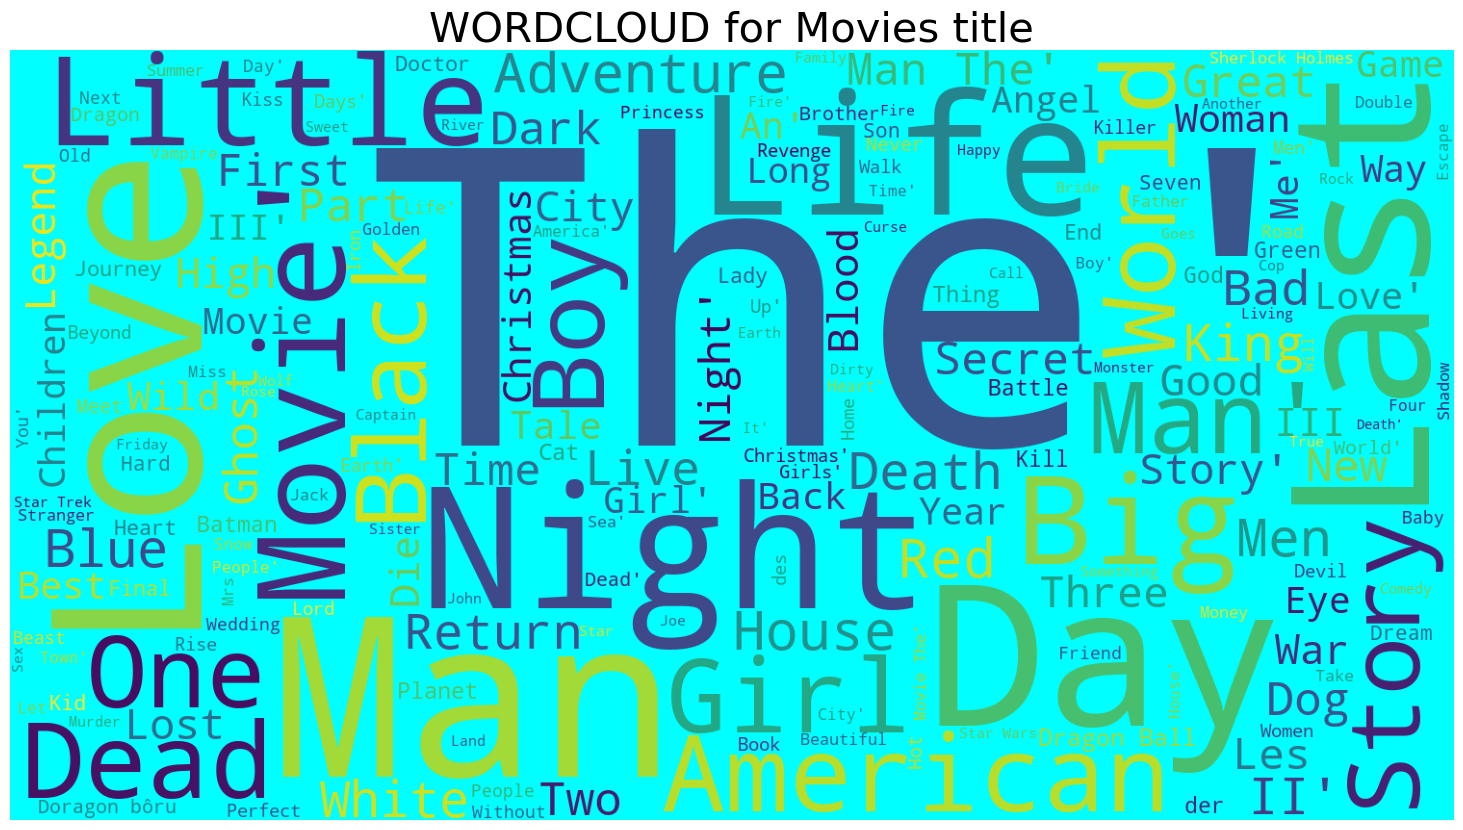

In [16]:
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('WORDCLOUD for Movies title',fontsize=30)
plt.imshow(wordcloud_title)

In [17]:
df=pd.merge(ratings,movies, how='left',on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [18]:
df1=df.groupby(['title'])[['rating']].sum()
high_rated=df1.nlargest(20,'rating')
high_rated.head()

,rating
title,
"Shawshank Redemption, The (1994)",1404.0
Forrest Gump (1994),1370.0
Pulp Fiction (1994),1288.5
"Matrix, The (1999)",1165.5
"Silence of the Lambs, The (1991)",1161.0


<BarContainer object of 20 artists>

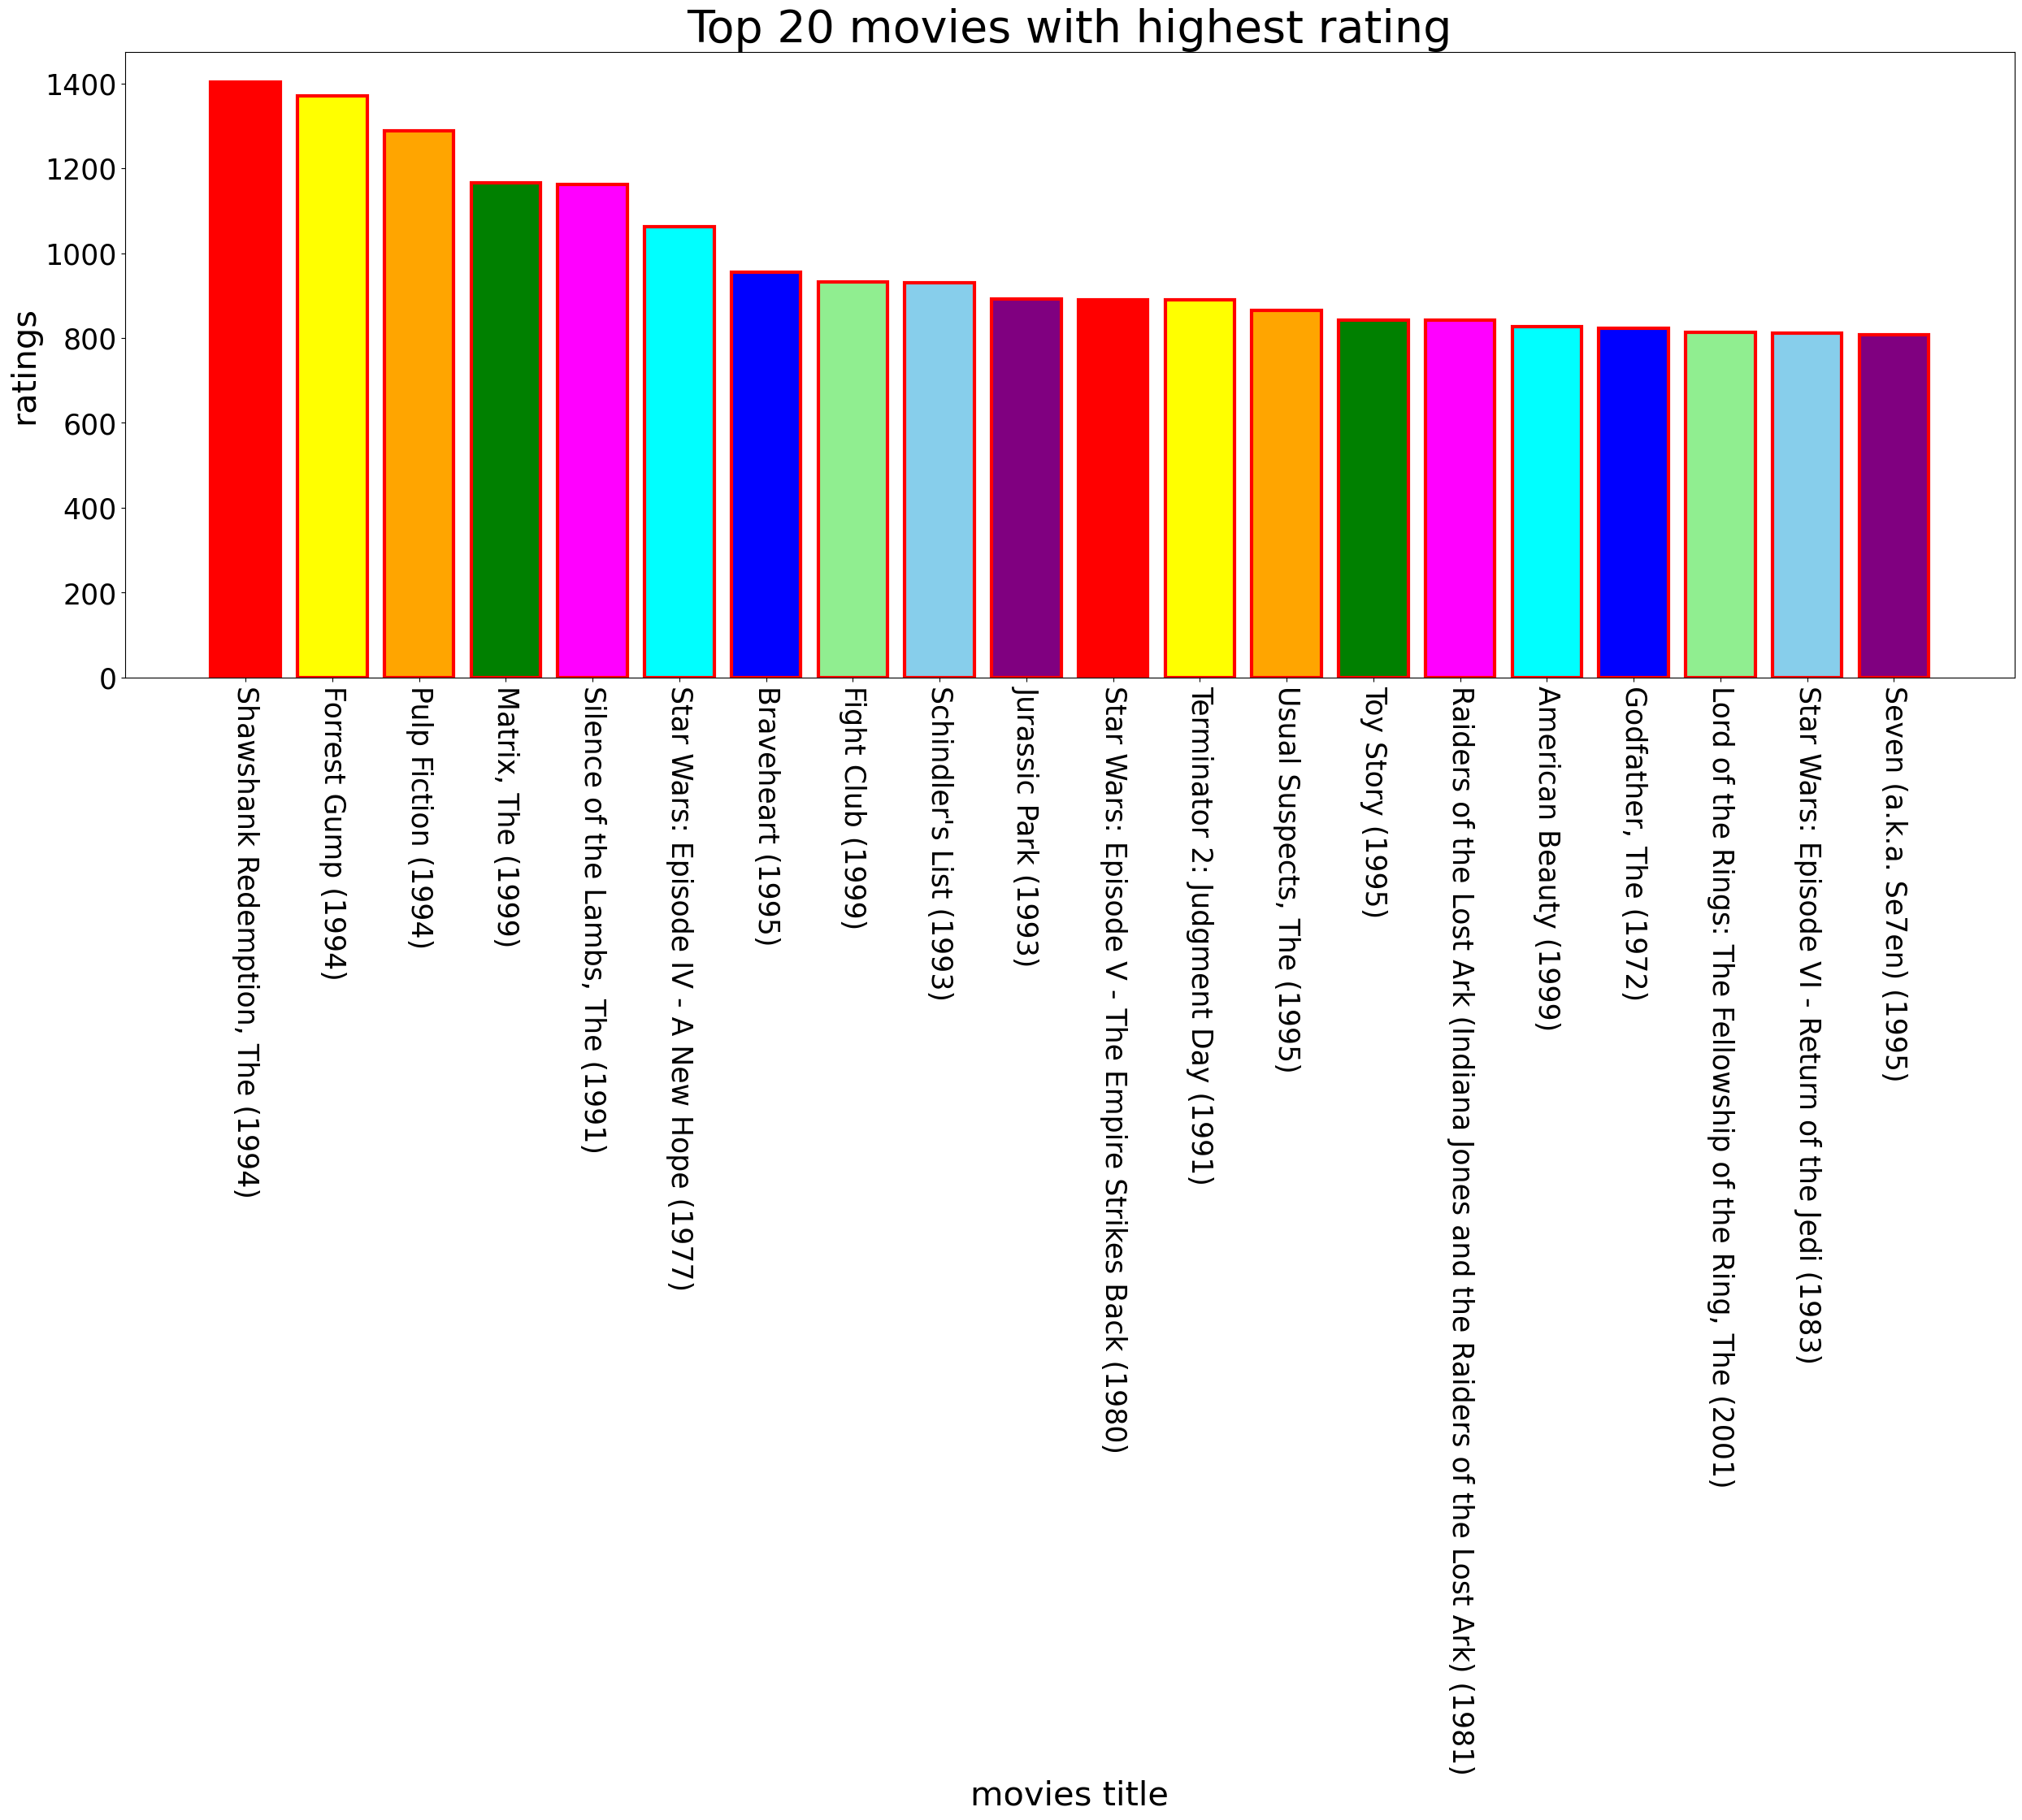

In [19]:
plt.figure(figsize=(30,10))
plt.title('Top 20 movies with highest rating',fontsize=40)
colors=['red','yellow','orange','green','magenta','cyan','blue','lightgreen','skyblue','purple']
plt.ylabel('ratings',fontsize=30)
plt.xticks(fontsize=25,rotation=-90)
plt.xlabel('movies title',fontsize=30)
plt.yticks(fontsize=25)
plt.bar(high_rated.index,high_rated['rating'],linewidth=3,edgecolor='red',color=colors)

In [20]:
df2=df.groupby('title')[['rating']].count()
rating_count_20=df2.nlargest(20,'rating')
rating_count_20.head()

,rating
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278


<BarContainer object of 20 artists>

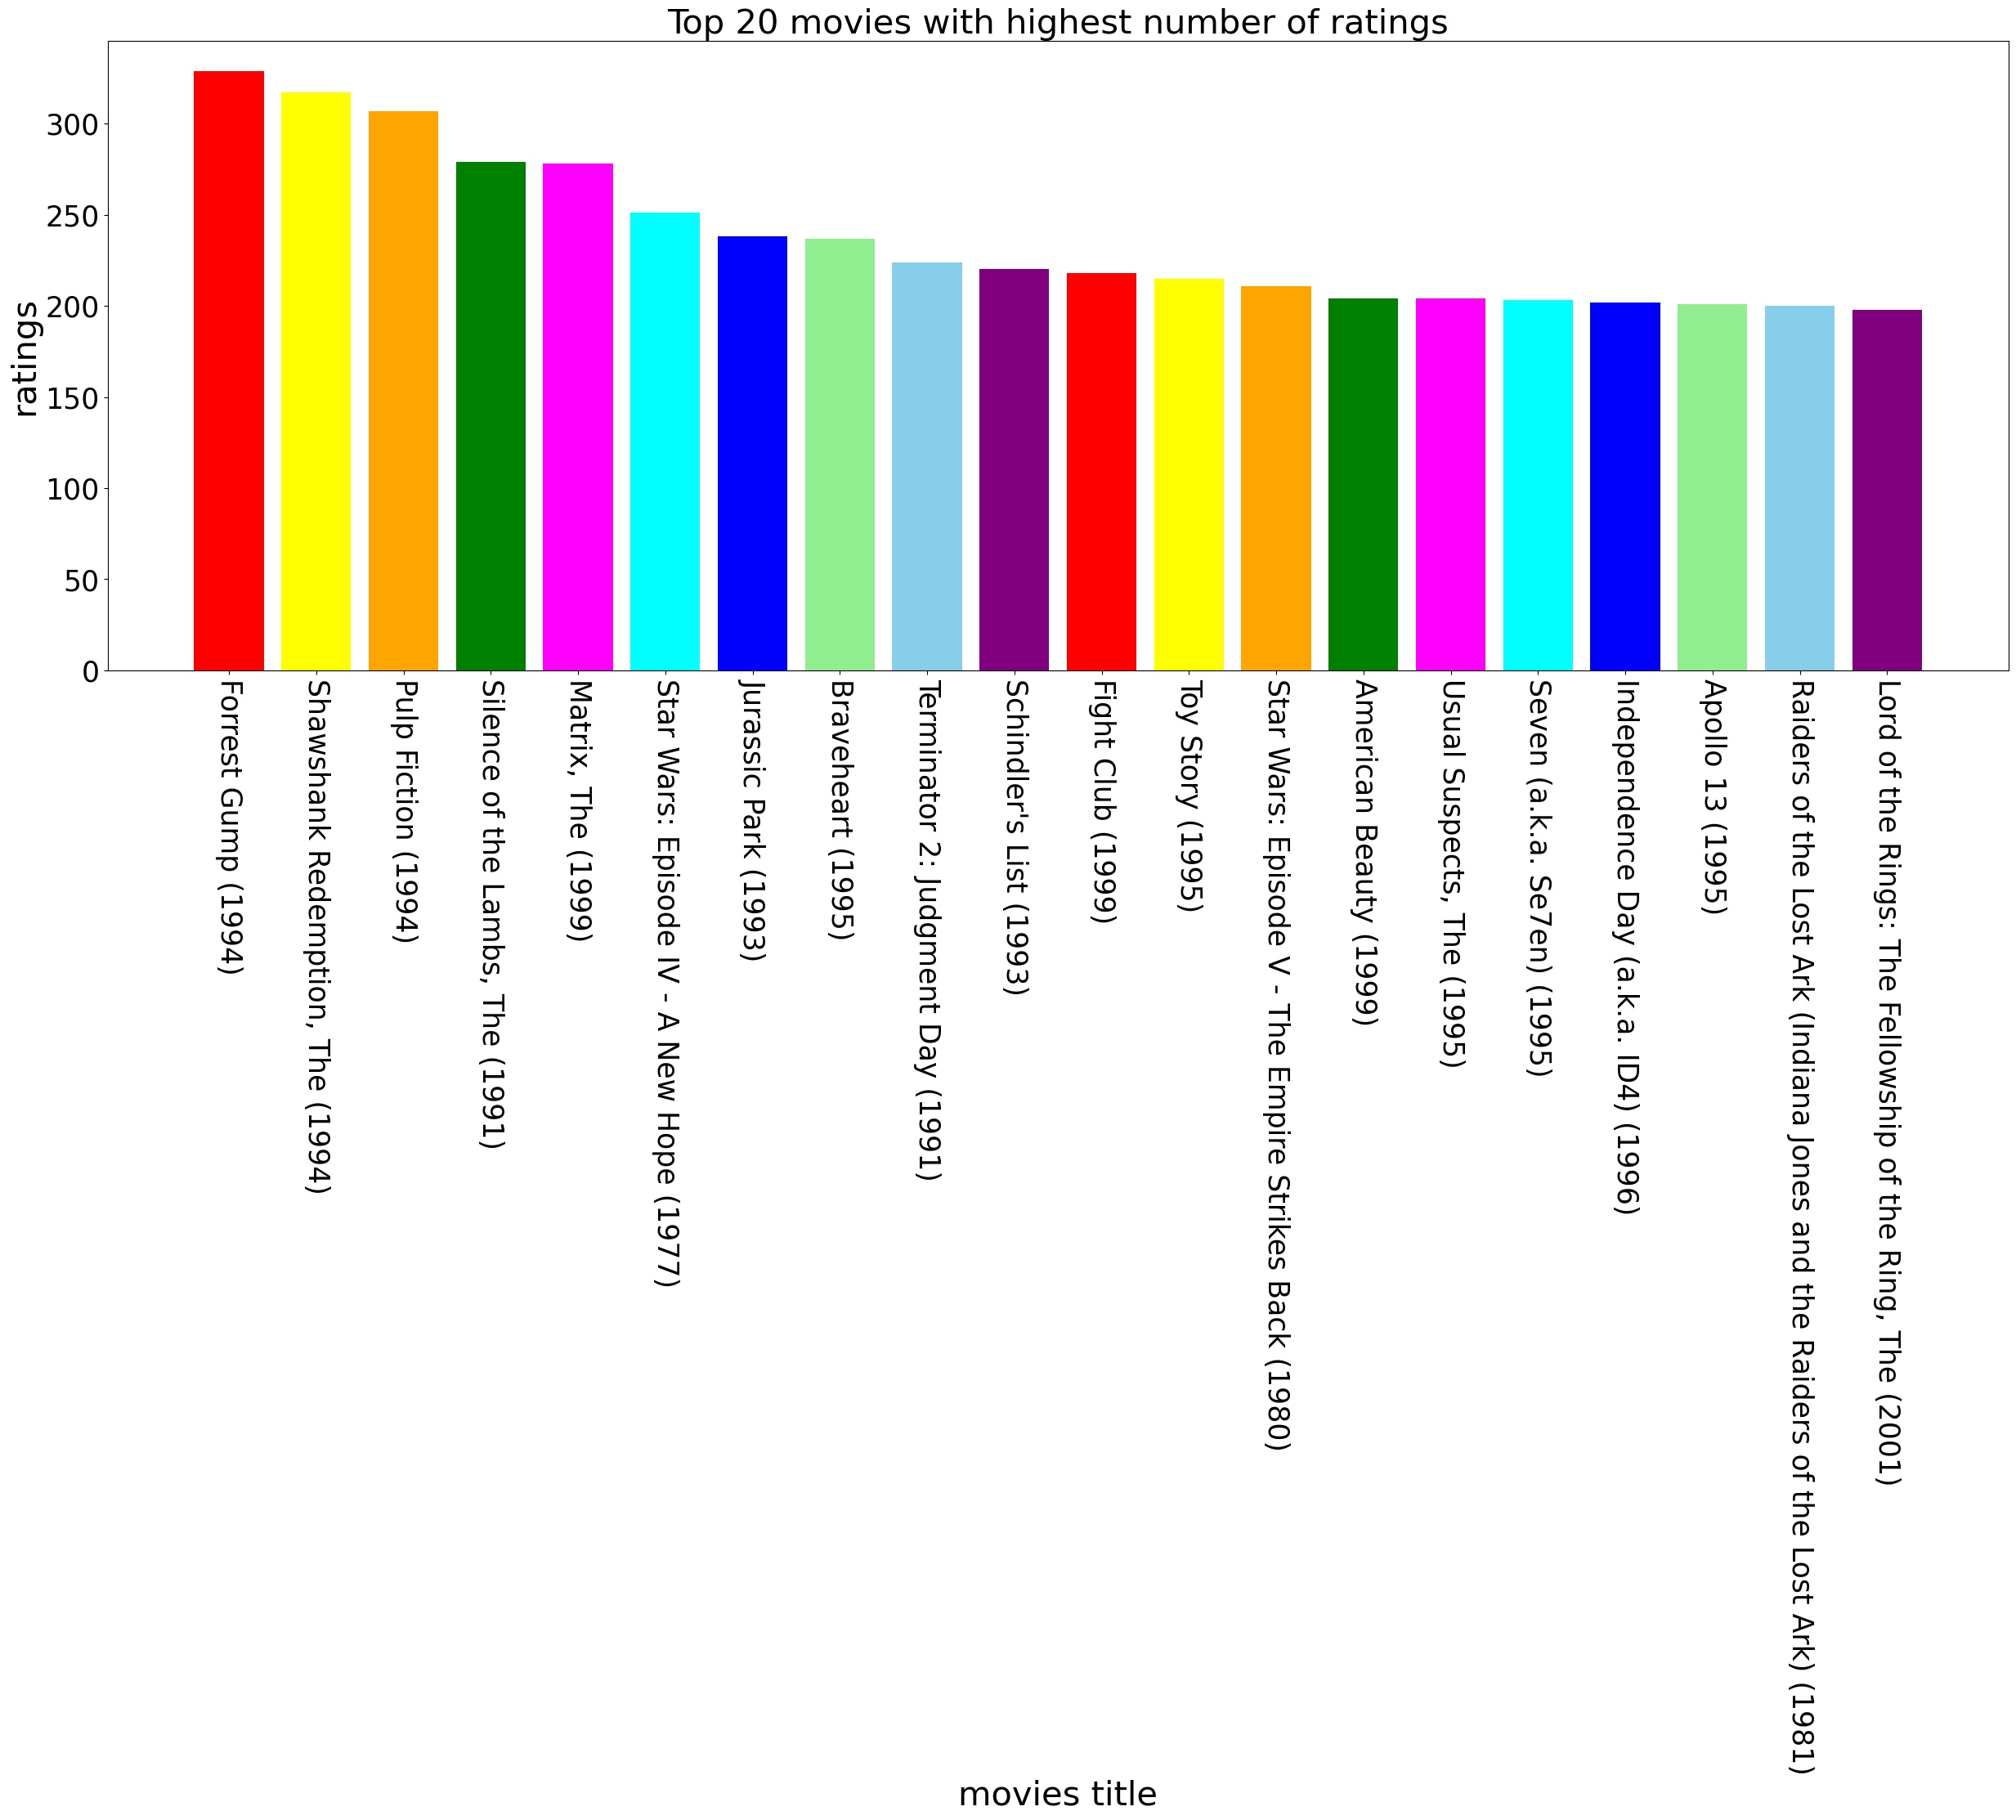

In [21]:
plt.figure(figsize=(30,10))
plt.title('Top 20 movies with highest number of ratings',fontsize=30)
plt.xticks(fontsize=25,rotation=-90)
plt.yticks(fontsize=25)
plt.xlabel('movies title',fontsize=30)
plt.ylabel('ratings',fontsize=30)

colors=['red','yellow','orange','green','magenta','cyan','blue','lightgreen','skyblue','purple']
plt.bar(rating_count_20.index,rating_count_20.rating,color= colors)

In [22]:
rating_count = df['rating'].value_counts().sort_index()
rating_count = pd.DataFrame({'rating': rating_count.index, 'movie_count': rating_count.values})

print(rating_count)


   rating  movie_count
0     0.5         1370
1     1.0         2811
2     1.5         1791
3     2.0         7551
4     2.5         5550
5     3.0        20047
6     3.5        13136
7     4.0        26818
8     4.5         8551
9     5.0        13211


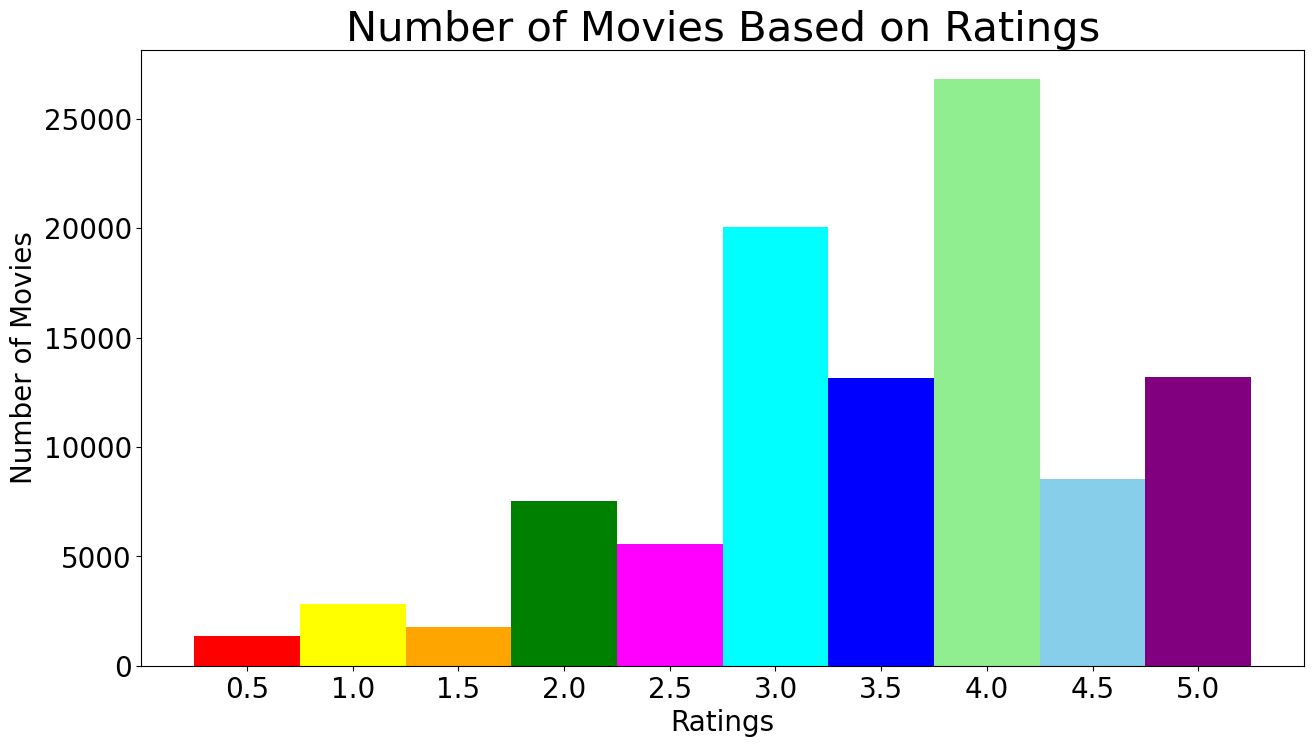

In [23]:

plt.figure(figsize=(15, 8))  # Adjust the figure size as needed
plt.title('Number of Movies Based on Ratings', fontsize=30)
plt.xticks(rating_count.rating,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Ratings', fontsize=20)
plt.ylabel('Number of Movies', fontsize=20)

colors = ['red', 'yellow', 'orange', 'green', 'magenta', 'cyan', 'blue', 'lightgreen', 'skyblue', 'purple']

bar_width = 0.5

#x_labels = [str(rating) for rating in rating_count.rating]

plt.bar(rating_count.rating, rating_count.movie_count, color=colors, width=bar_width)
#plt.xticks(rating_count.rating, x_labels)  # Set the x-axis tick positions and labels

plt.show()

## Item-Based Collaborative Technique

In [24]:
df = pd.read_csv('ratings.csv')

user_movie_ratings = df.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating', 
    fill_value=0
)

subset_user_movie_ratings = user_movie_ratings.iloc[:10, :10]  # Subset for visualization
print("User-Movie Ratings Matrix (Subset):")
print(subset_user_movie_ratings)


User-Movie Ratings Matrix (Subset):
movieId   1    2    3    4    5    6    7   8    9    10
userId                                                  
1        4.0  0.0  4.0  0.0  0.0  4.0  0.0   0  0.0  0.0
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0
5        4.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0
6        0.0  4.0  5.0  3.0  5.0  4.0  4.0   3  0.0  3.0
7        4.5  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0
8        0.0  4.0  0.0  0.0  0.0  0.0  0.0   0  0.0  2.0
9        0.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0
10       0.0  0.0  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0


In [25]:


# Calculate item-item similarity using cosine similarity
item_similarity = cosine_similarity(user_movie_ratings.T)

# Create a DataFrame from the item similarity matrix
item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_ratings.columns, columns=user_movie_ratings.columns)
print("\nItem Similarity Matrix (Subset):")
print(item_similarity_df.iloc[:10, :7])




Item Similarity Matrix (Subset):
movieId         1         2         3         4         5         6         7
movieId                                                                      
1        1.000000  0.410562  0.296917  0.035573  0.308762  0.376316  0.277491
2        0.410562  1.000000  0.282438  0.106415  0.287795  0.297009  0.228576
3        0.296917  0.282438  1.000000  0.092406  0.417802  0.284257  0.402831
4        0.035573  0.106415  0.092406  1.000000  0.188376  0.089685  0.275035
5        0.308762  0.287795  0.417802  0.188376  1.000000  0.298969  0.474002
6        0.376316  0.297009  0.284257  0.089685  0.298969  1.000000  0.244105
7        0.277491  0.228576  0.402831  0.275035  0.474002  0.244105  1.000000
8        0.131629  0.172498  0.313434  0.158022  0.283523  0.147562  0.273757
9        0.232586  0.044835  0.304840  0.000000  0.335058  0.214088  0.162000
10       0.395573  0.417693  0.242954  0.095598  0.218061  0.386414  0.238949


In [26]:
def evaluate_recommendations(user_id, user_movie_ratings, item_similarity_df):
    user_ratings = user_movie_ratings.loc[user_id]
    
    # Calculate the weighted average of similar movies
    recommendation_scores = item_similarity_df.dot(user_ratings)
    
    # Exclude already rated movies from recommendations
    unrated_movies = user_ratings[user_ratings == 0].index
    recommended_movies = recommendation_scores[unrated_movies].sort_values(ascending=False).index
    
    # Example: assuming actual ratings are known for evaluation
    actual_ratings = user_movie_ratings.loc[user_id]
    
    mae = mean_absolute_error(actual_ratings, recommendation_scores)
    rmse = mean_squared_error(actual_ratings, recommendation_scores, squared=False)
    
    return mae, rmse

# Example usage for evaluation
user_id = 1
mae, rmse = evaluate_recommendations(user_id, user_movie_ratings, item_similarity_df)
print(f'MAE: {mae}, RMSE: {rmse}')


MAE: 94.17461678850529, RMSE: 116.86523652484699


## Item-based with SVD

In [27]:
# Initialize a Reader
reader = Reader()

# Create a Dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define hyperparameters for SVD
params = {'n_factors': 50,  # Number of latent factors
          'n_epochs': 20,  # Number of iterations
          'lr_all': 0.005,  # Learning rate for all parameters
          'reg_all': 0.02}  # Regularization term for all parameters

# Create and train the SVD model with hyperparameters
model = SVD(**params)
model.fit(trainset)

# Save the trained model using pickle
model_filename = 'item_based_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(item_similarity_df, model_file)

# Calculate item-item similarity using cosine similarity
user_movie_ratings = df.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating', 
    fill_value=0
)

# Apply Inverse User Frequency Weighting
user_freq = user_movie_ratings.astype(bool).sum(axis=0)
user_freq_weights = 1 / (1 + np.log(user_freq))
user_freq_weights = user_freq_weights.values.reshape(-1, 1)  # Reshape to match dimensions
item_similarity_weighted = user_freq_weights * cosine_similarity(user_movie_ratings.T)

# Create a DataFrame from the weighted item similarity matrix
item_similarity_df = pd.DataFrame(item_similarity_weighted, index=user_movie_ratings.columns, columns=user_movie_ratings.columns)

    
def evaluate_recommendations(user_id, user_movie_ratings, item_similarity_df):
    user_ratings = user_movie_ratings.loc[user_id]
    
    # Calculate the weighted average of similar movies
    recommendation_scores = item_similarity_df.dot(user_ratings)
    
    # Exclude already rated movies from recommendations
    unrated_movies = user_ratings[user_ratings == 0].index
    recommended_movies = recommendation_scores[unrated_movies].sort_values(ascending=False).index
    
    # Example: assuming actual ratings are known for evaluation
    actual_ratings = user_movie_ratings.loc[user_id]
    
    mae_score = np.mean(np.abs(actual_ratings.values - recommendation_scores.values))
    rmse_score = np.sqrt(np.mean(np.square(actual_ratings.values - recommendation_scores.values)))
    
    return mae_score, rmse_score

# Example usage for evaluation
user_id = 1
mae_score, rmse_score = evaluate_recommendations(user_id, user_movie_ratings, item_similarity_df)
print(f'MAE: {mae_score}, RMSE: {rmse_score}')


MAE: 41.723848502069394, RMSE: 48.767783364210395


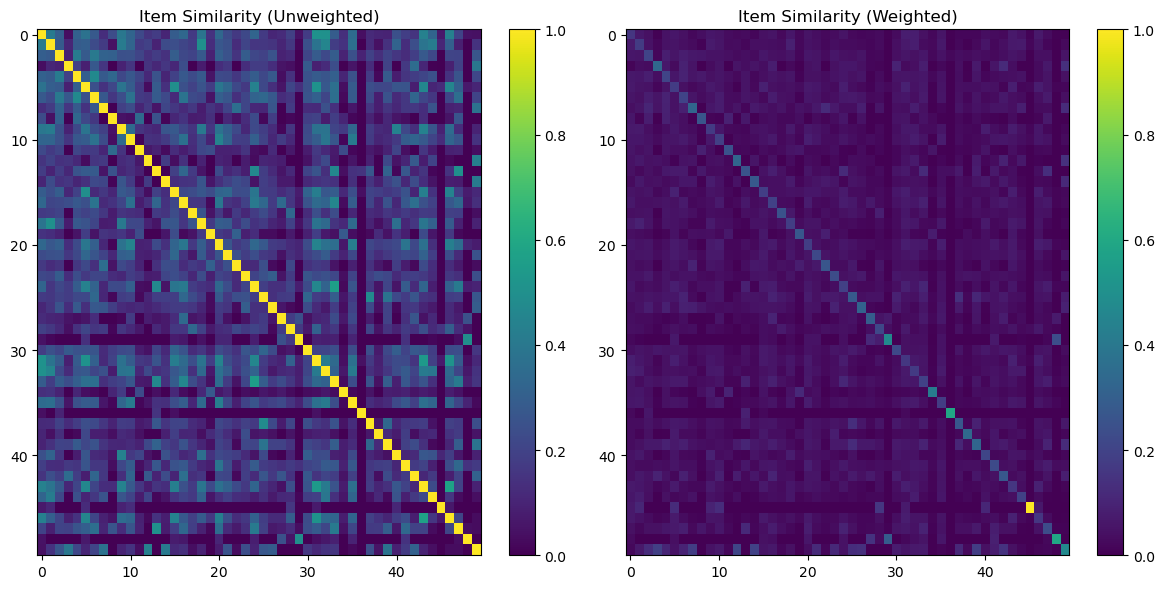

In [28]:
# Choose a subset of items for visualization (e.g., first 50 items)
subset_items = user_movie_ratings.columns[:50]

# Calculate cosine similarity without weighting
item_similarity = cosine_similarity(user_movie_ratings[subset_items].T)

# Apply Inverse User Frequency Weighting to the subset
subset_user_freq = user_freq[subset_items]
subset_user_freq_weights = 1 / (1 + np.log(subset_user_freq))
subset_user_freq_weights = subset_user_freq_weights.values.reshape(-1, 1)
subset_item_similarity_weighted = subset_user_freq_weights * item_similarity

# Plot the similarity matrices side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(item_similarity, cmap='viridis', aspect='auto')
plt.title('Item Similarity (Unweighted)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(subset_item_similarity_weighted, cmap='viridis', aspect='auto')
plt.title('Item Similarity (Weighted)')
plt.colorbar()

plt.tight_layout()
plt.show()

## User-based with SVD

In [29]:
# Load your dataset
df = pd.read_csv('ratings.csv')

# Initialize a Reader
reader = Reader()

# Create a Dataset
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define hyperparameters for SVD
params = {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

# Create and train the SVD model with hyperparameters
model = SVD(**params)
model.fit(trainset)

# Save the trained model
model_filename = 'user_based_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

# Perform cross-validation
cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("Cross-validation RMSE:", cv_results['test_rmse'].mean())
print("Cross-validation MAE:", cv_results['test_mae'].mean())



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8685  0.8736  0.8682  0.8753  0.8662  0.8703  0.0035  
MAE (testset)     0.6701  0.6692  0.6651  0.6730  0.6683  0.6691  0.0026  
Fit time          2.26    2.33    2.32    2.30    2.24    2.29    0.04    
Test time         0.10    0.18    0.10    0.18    0.09    0.13    0.04    
Cross-validation RMSE: 0.8703314401578097
Cross-validation MAE: 0.6691335559275391


## Deployment

## User-based movie recommendation system

In [30]:
# Load the saved model
model_filename = 'user_based_model.pkl'
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
    
movie_ids = ratings['movieId'].unique()

# Create the main window
root = tk.Tk()
root.title("Movie Recommendation System")

# Create and place widgets
max_user_id = df['userId'].max()
user_id_label = tk.Label(root, text=f"Enter your user ID (Maximum User ID: {max_user_id}):")
user_id_label.pack()

user_id_entry = tk.Entry(root)
user_id_entry.pack()

get_recommendations_button = tk.Button(root, text="Get Recommendations")

def get_recommendations():
    user_id = user_id_entry.get()

    if user_id:
        user_id = int(user_id)
        
        # Predict ratings for all movies for the chosen user
        user_ratings = [{'movieId': movie_id, 'rating': model.predict(user_id, movie_id).est} for movie_id in movie_ids]
        
        
        # Sort the predicted ratings in descending order and get top 10 recommendations
        top_recommendations = sorted(user_ratings, key=lambda x: x['rating'], reverse=True)[:10]
        
        recommendations_text.delete(1.0, tk.END)  # Clear previous recommendations
        
        for idx, rec in enumerate(top_recommendations, start=1):
            recommendations_text.insert(tk.END, f"{idx}. MovieId: {rec['movieId']}, Estimated Rating: {rec['rating']:.2f}\n")

get_recommendations_button.config(command=get_recommendations)
get_recommendations_button.pack()

recommendations_text = tk.Text(root, height=20, width=70)
recommendations_text.pack()

root.mainloop()

In [31]:


# Read data and preprocess
df = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies['genres'].apply(lambda x: x.split('|')))
genre_sparse = csr_matrix(genre_matrix)

# Calculate genre similarity matrix
genre_similarity = cosine_similarity(genre_sparse)

# Load the trained SVD model
with open('user_based_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Create a Tkinter GUI
root = Tk()
root.title("Movie Recommender based on genre")

max_user_id = df['userId'].max()
user_label = Label(root, text=f"Enter your user ID (Maximum User ID: {max_user_id}):")
user_label.pack()

user_entry = Entry(root)
user_entry.pack()

genre_label = Label(root, text="Select a genre:")
genre_label.pack()

# Get the unique genres
unique_genres = mlb.classes_
genre_var = StringVar(value=unique_genres[0])
genre_dropdown = OptionMenu(root, genre_var, *unique_genres)
genre_dropdown.pack()

recommendations_text = Text(root, height=20, width=70)
recommendations_text.pack()

def recommend_movies():
    user_id = int(user_entry.get())
    input_genre = genre_var.get()
    
    # Find the index of the selected genre
    input_genre_idx = mlb.classes_.tolist().index(input_genre)
    
    # Get movies that match the selected genre
    genre_movies = movies[movies['genres'].str.contains(input_genre)]
    
    # Use the trained model to predict ratings for the genre movies
    genre_movie_ids = genre_movies['movieId'].tolist()
    genre_movie_ratings = [(user_id, movie_id, model.predict(user_id, movie_id)
                            .est) for movie_id in genre_movie_ids]
    
    # Sort the recommended genre movies by predicted rating
    genre_movie_ratings.sort(key=lambda x: x[2], reverse=True)
    
    # Display the recommendations
    recommendations_text.delete(1.0, END)
    for idx, (user_id, movie_id, rating) in enumerate(genre_movie_ratings[:10], start=1):
        recommendations_text.insert(END, f"{idx}. Movie id: {movie_id}, Predicted Rating: {rating:.2f}\n")

recommend_button = Button(root, text="Recommend Movies", 
                          command=recommend_movies)
recommend_button.pack()

root.mainloop()


### Item based recommendation system

In [ ]:
# Load your cleaned DataFrame
# Replace this with loading your actual cleaned DataFrame
df_clean = pd.read_csv('ratings.csv')

# Create the main window
root = tk.Tk()
root.title("Movie Recommendation System for unwatched movie")

# Create and place widgets
input_label = tk.Label(root, text="Enter the movies you have watched (MovieId:Rating, separated by commas):")
input_label.pack()

range_label = tk.Label(root, text="MovieId range: {}-{}".format(df_clean['movieId'].min(), df_clean['movieId'].max()))
range_label.pack()

input_entry = tk.Entry(root)
input_entry.pack()

recommend_button = tk.Button(root, text="Get Recommendations")

def get_recommendations():
    user_input = input_entry.get()
    user_input = user_input.strip().split(',')
    
    if user_input:
        user_ratings = []
        for item in user_input:
            try:
                movie_id, rating = map(float, item.split(':'))
                user_ratings.append({'userId': 611, 'movieId': int(movie_id), 'rating': float(rating)})
            except ValueError:
                messagebox.showerror("Error", "Invalid input format. Use MovieId:Rating format.")
                return
        
        user_df = pd.DataFrame(user_ratings)
        print('user_df:\n', user_df)
        user_watched_movie_ids = set(user_df['movieId'])
        
        # Load the item-based collaborative filtering model
        model_filename = 'item_based_model.pkl'
        with open(model_filename, 'rb') as model_file:
            item_similarity_df = pickle.load(model_file)
        
        # Generate recommendations for unwatched movies
        unwatched_movie_ids = list(set(df_clean['movieId'].unique()) )
        
        # Initialize an empty DataFrame to store recommendations
        recommendations = pd.DataFrame(index=unwatched_movie_ids, 
                                       columns=['Recommendation Score'])
        
        for movie_id in unwatched_movie_ids:
            # Calculate recommendation score for each unwatched movie
            similar_movies = item_similarity_df[movie_id]
            user_watched_ratings = user_df[user_df['movieId'].isin(similar_movies.index)]
            user_weighted_ratings = user_watched_ratings['rating'] * similar_movies[user_watched_ratings['movieId']]
            recommendation_score = user_weighted_ratings.sum() / similar_movies.sum() if similar_movies.sum() != 0 else 0
            recommendations.loc[movie_id, 'Recommendation Score'] = recommendation_score
        
        recommendations = recommendations.sort_values(by='Recommendation Score', ascending=False)[:10]
        
        recommendations_text.delete(1.0, tk.END)  # Clear previous recommendations
        
        for idx, (movie_id, score_row) in enumerate(recommendations.iterrows(), start=1):
            score = score_row['Recommendation Score']
            recommendations_text.insert(tk.END, f"{idx}. MovieId: {movie_id}, Recommendation Score: {score:.2f}\n")

recommend_button.config(command=get_recommendations)
recommend_button.pack()

recommendations_text = tk.Text(root, height=20, width=70)
recommendations_text.pack()

root.mainloop()


user_df:
    userId  movieId  rating
0     611        3     3.0
1     611        6     5.0
2     611       10     4.0
user_df:
    userId  movieId  rating
0     611      105     4.5
1     611        3     3.0
2     611        6     5.0
3     611       10     4.0
